In [3]:
import pandas as pd
import numpy as np
from itertools import combinations
import random

import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import confint_proportions_2indep
from statsmodels.stats.power import NormalIndPower
from scipy.stats import chi2_contingency
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests
from statsmodels.formula.api import logit
from scipy.optimize import minimize
from sklearn.metrics import roc_auc_score

#to suppress warnings
import warnings
warnings.filterwarnings('ignore',category=FutureWarning, module='pandas')
warnings.filterwarnings('ignore',category=FutureWarning, module='seaborn')

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.patches import Patch

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

%config InlineBackend.figure_format='retina'

#custom color

custom_colors = ['#F6BD60','#F7EDE2','#F5CAC3','#84A59D','#F28482']

sns.set_theme(context='paper', style='whitegrid', palette=custom_colors, font='sans-serif', font_scale=1, color_codes=True,
              rc={'grid.alpha': 0.5, 'axes.titlesize': 14, 'figure.figsize': (12,6)})

sns.color_palette(custom_colors)

[(0.9647058823529412, 0.7411764705882353, 0.3764705882352941),
 (0.9686274509803922, 0.9294117647058824, 0.8862745098039215),
 (0.9607843137254902, 0.792156862745098, 0.7647058823529411),
 (0.5176470588235295, 0.6470588235294118, 0.615686274509804),
 (0.9490196078431372, 0.5176470588235295, 0.5098039215686274)]

In [4]:
ad_campaign = pd.read_csv(r'C:\Users\heena\Downloads\marketing_AB.csv\marketing_AB.csv', index_col=0)
ad_campaign.head()

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


In [5]:
ad_campaign.info()

<class 'pandas.core.frame.DataFrame'>
Index: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user id        588101 non-null  int64 
 1   test group     588101 non-null  object
 2   converted      588101 non-null  bool  
 3   total ads      588101 non-null  int64 
 4   most ads day   588101 non-null  object
 5   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 27.5+ MB


In [6]:
ad_campaign['most ads day'].unique()

array(['Monday', 'Tuesday', 'Friday', 'Saturday', 'Wednesday', 'Sunday',
       'Thursday'], dtype=object)

In [7]:
np.sort(ad_campaign['most ads hour'].unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23], dtype=int64)

In [8]:
ad_campaign['test group'].unique()

array(['ad', 'psa'], dtype=object)

In [9]:
ad_campaign.isna().sum()

user id          0
test group       0
converted        0
total ads        0
most ads day     0
most ads hour    0
dtype: int64

In [10]:
Q1 = ad_campaign['total ads'].quantile(0.25)
Q3 = ad_campaign['total ads'].quantile(0.75)
IQR = Q3 - Q1

down_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

outliers = ad_campaign[(ad_campaign['total ads'] < down_limit) | (ad_campaign['total ads'] > upper_limit)]

n_outliers = len(outliers)
total_records = len(ad_campaign)
outlier_percentage = (n_outliers / total_records) * 100

print(f"Total Number of records: {total_records}")
print(f"Number of outliers: {n_outliers}")
print(f"Percentage of outliers: {outlier_percentage:.2f}%")

Total Number of records: 588101
Number of outliers: 52057
Percentage of outliers: 8.85%


In [11]:
print('Outliers Statistics')
print(outliers['total ads'].describe())
print('\nNon-outliers Statstics')
print(ad_campaign[~ad_campaign.index.isin(outliers.index)]['total ads'].describe())

Outliers Statistics
count   52057.0000
mean      124.5689
std        92.9344
min        62.0000
25%        74.0000
50%        94.0000
75%       136.0000
max      2065.0000
Name: total ads, dtype: float64

Non-outliers Statstics
count   536044.0000
mean        15.1340
std         14.0636
min          1.0000
25%          4.0000
50%         11.0000
75%         22.0000
max         61.0000
Name: total ads, dtype: float64


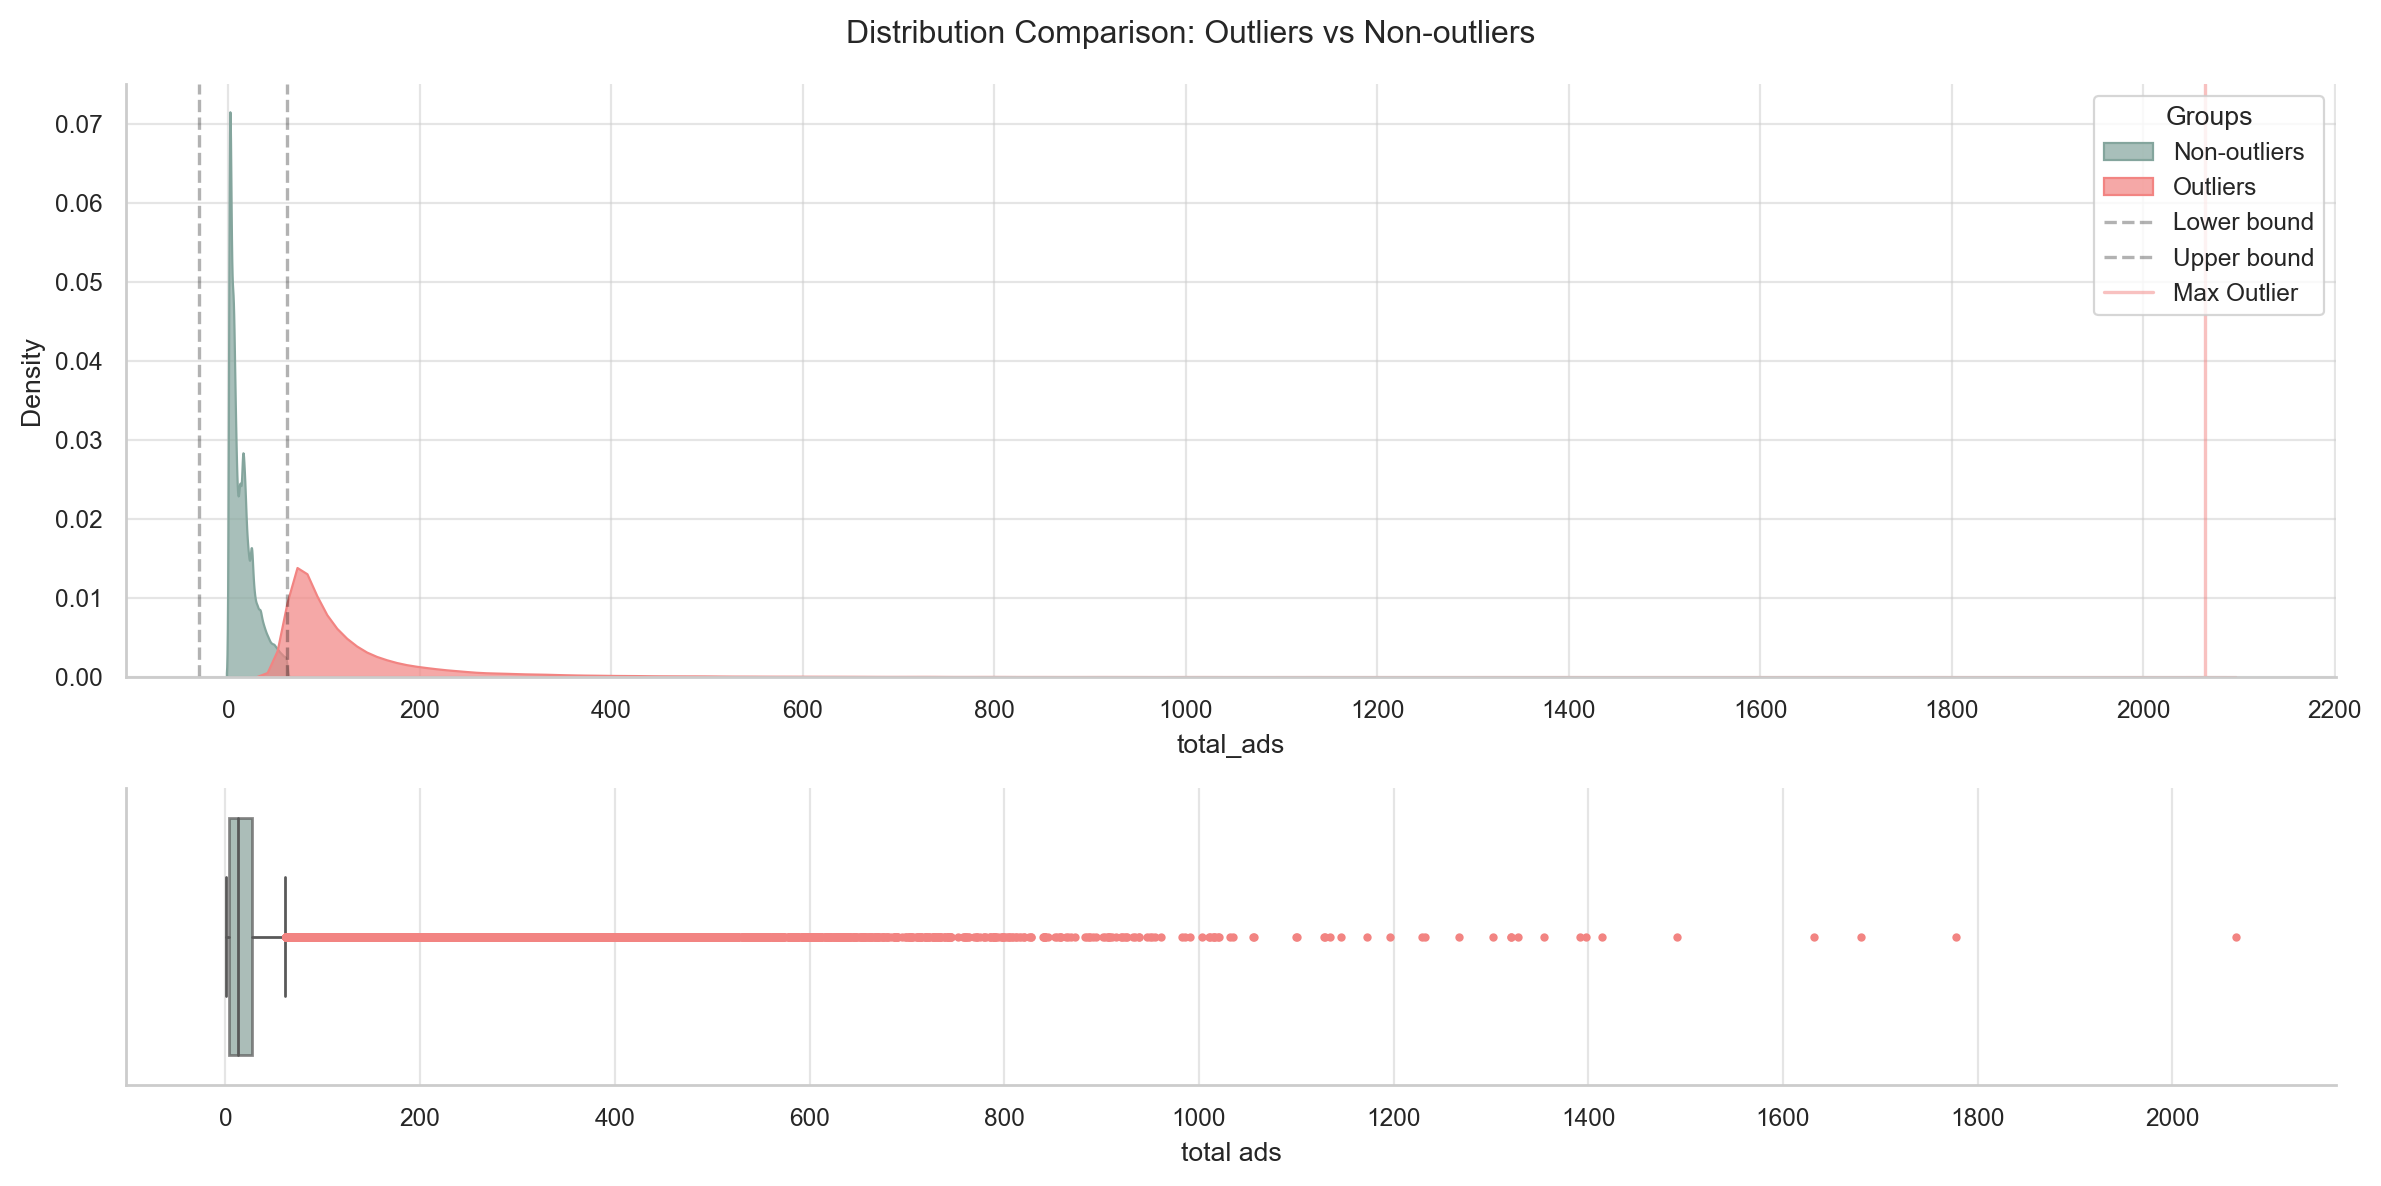

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, height_ratios=[2, 1])

sns.kdeplot(data=ad_campaign[~ad_campaign.index.isin(outliers.index)]['total ads'], label='Non-outliers',
           fill=True,
           alpha=0.7,
           color=custom_colors[3],
           ax=ax1
)

sns.kdeplot(data=outliers['total ads'], label='Outliers', fill=True, alpha=0.7, color=custom_colors[4], ax=ax1)
ax1.axvline(x=down_limit, color='black', linestyle='--', alpha=0.3, label='Lower bound')
ax1.axvline(x=upper_limit, color='black', linestyle='--', alpha=0.3, label='Upper bound')
ax1.axvline(x=outliers['total ads'].max(), color=custom_colors[4], linestyle='-', alpha=0.5, label='Max Outlier')

# Customize first subplot
ax1.set_xlabel('total_ads')
ax1.set_ylabel('Density')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(200))
ax1.legend(title='Groups', loc='upper right')

# Second subplot: Boxplot of 'total_ads' distribution
sns.boxplot(x=ad_campaign['total ads'], ax=ax2, color=custom_colors[3], boxprops=dict(alpha=.7),
           linewidth=1, flierprops={'marker': 'o', 'markersize': 2, 'markerfacecolor': custom_colors[4],
           'markeredgecolor': custom_colors[4]})

ax2.set_xlabel('total ads')
ax2.xaxis.set_major_locator(ticker.MultipleLocator(200))

# Add figure title
fig.suptitle('Distribution Comparison: Outliers vs Non-outliers')
# Adjust layout to prevent overlap
plt.tight_layout()
# Remove the top and right spines
[ax.spines[side].set_visible(False) for ax in [ax1, ax2] for side in ['top', 'right']]
plt.show()

In [14]:
no_outliers_df = ad_campaign[~ad_campaign.index.isin(outliers.index)]

mean_ads_overall = ad_campaign['total ads'].mean()
mean_ads_no_outliers = no_outliers_df['total ads'].mean()
print(f'Avg. ads seen overall: {mean_ads_overall:.0f} ads')
print(f'Avg. ads seen without outliers: {mean_ads_no_outliers:.0f} ads')

Avg. ads seen overall: 25 ads
Avg. ads seen without outliers: 15 ads


In [15]:
# Calculate overall conversion rate
conversion_rate = (ad_campaign['converted'] == True).mean() * 100
print(f'Overal conversion rate (with outliers): {conversion_rate:.2f}%')

# Calculate conversion rate for the filtered dataset
no_outliers_conversion_rate = (no_outliers_df['converted'] == True).mean() * 100
print(f'Conversion rate without outliers: {no_outliers_conversion_rate:.2f}%')

# Calculate the relative difference in conversion rates
relative_diff = ((conversion_rate - no_outliers_conversion_rate) / conversion_rate) * 100
print(f"\nRelative difference in conversion rates: {relative_diff:.2f}%")

Overal conversion rate (with outliers): 2.52%
Conversion rate without outliers: 1.33%

Relative difference in conversion rates: 47.41%


In [16]:
# Check the origin of outliers
print('Outliers conversion distribution by test_group\n')
outliers_pivot = (outliers.groupby('test group')['converted']).value_counts(normalize=True).unstack() * 100
outliers_pivot

Outliers conversion distribution by test_group



converted,False,True
test group,,
ad,84.8900,15.1100
psa,91.1658,8.8342


In [17]:
# Check the percent of converted users among outliers
outliers_conversion = outliers['converted'].value_counts(normalize=True).mul(100).round(2).reset_index()
print(f'Outliers Conversion Rate: {outliers_conversion.iloc[1,1]:.2f} %')

Outliers Conversion Rate: 14.85 %


In [18]:
ad_campaign.head(1)

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20


In [19]:
ad_campaign.rename(columns={
    'user id': 'user_id',
    'test group': 'test_group',
    'total ads': 'total_ads',
    'most ads day': 'most_ads_day',
    'most ads hour': 'most_ads_hour'
}, inplace=True)

In [21]:
ad_campaign['converted'] = ad_campaign['converted'].astype(int)

In [23]:
ad_campaign_clean = ad_campaign[~((ad_campaign['total_ads'] < down_limit) | (ad_campaign['total_ads'] > upper_limit))]
ad_campaign_clean = ad_campaign_clean.reset_index(drop=True)
ad_campaign_clean.head()

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,1144181,ad,0,21,Tuesday,18
1,1496843,ad,0,17,Sunday,18
2,1448851,ad,0,21,Tuesday,19
3,1637531,ad,0,47,Wednesday,13
4,1081965,ad,0,61,Tuesday,20


In [24]:
#campaign effectiveness

In [25]:
treatment_group = ad_campaign_clean[ad_campaign_clean['test_group'] == 'ad']
control_group = ad_campaign_clean[ad_campaign_clean['test_group'] == 'psa']

In [26]:
 # Calculate conversion rates in both groups (treatment and control)
treatment_conversion_rate = (treatment_group['converted'] == True).mean()
print(f'Treatment Group Conversion rate: {treatment_conversion_rate:.2%}')

control_conversion_rate = (control_group['converted'] == True).mean()
print(f'Control Group Conversion rate: {control_conversion_rate:.2%}')

# Calculate absolute difference abf relative lift in conversion
diff = treatment_conversion_rate - control_conversion_rate
print(f'\nAbsolute difference: {diff:.2%}')

rel_lift = ((treatment_conversion_rate - control_conversion_rate)/control_conversion_rate)
print(f'Relative Lift in conversion {rel_lift:.2%}')

Treatment Group Conversion rate: 1.34%
Control Group Conversion rate: 1.06%

Absolute difference: 0.28%
Relative Lift in conversion 26.31%


In [29]:
def assump_check(control_group, treatment_group, target_col, user_id_col):
    # Normality
    n_control = len(control_group)
    p_control = control_group[target_col].mean()
    control_assumption = n_control * p_control * (1 - p_control)

    n_treatment = len(treatment_group)
    p_treatment = treatment_group[target_col].mean()
    treatment_assumption = n_treatment * p_treatment * (1 - p_treatment)

    # Independence
    # 1.Within groups duplicates
    duplicates_treatment = treatment_group[user_id_col].duplicated().sum()
    duplicates_control = control_group[user_id_col].duplicated().sum()

    # 2.Between groups duplicates (overlap)
    treatment_users = set(treatment_group[user_id_col])
    control_users = set(control_group[user_id_col])
    overlapping_users_num = len(treatment_users.intersection(control_users))
    
     # Calculate ratio for reporting group size difference
    ratio = n_treatment/n_control
    print(f'Treatment/Control ratio: {ratio:.2f}')

    # Check conditions for parametric test
    if (control_assumption >= 10 and treatment_assumption >= 10 and
        duplicates_treatment == 0 and duplicates_control == 0 and
        overlapping_users_num == 0):
        return 'The Assumption for Parametric were met. Conduct the Two-proportion Z-test.'
    else:
        return 'The Assumption for Parametric were NOT met. Conduct the Chi-square Homogeneity test.'

In [30]:
assump_check(control_group, treatment_group, 'converted', 'user_id')

Treatment/Control ratio: 24.13


'The Assumption for Parametric were met. Conduct the Two-proportion Z-test.'

In [31]:
#Conducting two-proportion z-test

In [32]:
# Data Preparation
# Count successes (conversions)
successes = [
    sum(treatment_group['converted'] == True),    # number of conversions in ad group
    sum(control_group['converted'] == True)    # number of conversions in psa group
]

# Get sample sizes
nobs = [
    len(treatment_group),    # total number in ad group
    len(control_group)    # total number in psa group
]

# Calculate proportions
p_ad = successes[0]/nobs[0]
p_psa = successes[1]/nobs[1]

# Conduct one-tailed Two-proportion Z-test
z_stat, p_value = proportions_ztest(count=successes, 
                                 nobs=nobs,
                                 alternative='larger')

if p_value < 0.05:
    print("Reject the Null Hypothesis: The 'ad' group has a significantly higher conversion rate than the 'psa' group.\nThe ad campaign shows statistically significant improvement.")
else:
    print("Fail to reject the Null Hypothesis: There is no statistically significant evidence that the 'ad' group has a higher conversion rate than the 'psa' group.")

Reject the Null Hypothesis: The 'ad' group has a significantly higher conversion rate than the 'psa' group.
The ad campaign shows statistically significant improvement.


In [33]:
# Calculate CI
ci = confint_proportions_2indep(
    count1=successes[0],  # successes in ad(treatment) group
    nobs1=nobs[0],        # total in ad group
    count2=successes[1],  # successes in psa(control) group
    nobs2=nobs[1],        # total in psa group
    alpha=0.05            # for 95% CI
)

print(f'95% CI for difference in proportions: ({ci[0]:.2%} - {ci[1]:.2%})')
print(f'\nCurrent Conversion Rate difference: {diff:.2%}')

95% CI for difference in proportions: (0.13% - 0.41%)

Current Conversion Rate difference: 0.28%


In [34]:
# Calculate effect size - Cohen's h(specifically designed for difference between proportions)
effect_size = 2 * (np.arcsin(np.sqrt(p_ad)) - np.arcsin(np.sqrt(p_psa)))

# Effect size interpretation
def interpret_cohens_h(h):
   if abs(h) < 0.2:
       return "Small: "
   elif abs(h) < 0.5:
       return "Medium"
   else:
       return "Large"

print(f"\nEffect Size Interpretation:")
print(f"Cohen's h = {effect_size:.4f} ({interpret_cohens_h(effect_size)} effect)")

# The transformed proportion in ad group is 0.0257 standard units higher than the transformed proportion in PSA group.


Effect Size Interpretation:
Cohen's h = 0.0257 (Small:  effect)


In [35]:
# Initialize the power analysis
power_analysis = NormalIndPower()

# Calculate effect size using Cohen's h
def cohen_h(p1, p2):
    return 2 * (np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2)))

# Calculate power
power = power_analysis.solve_power(
    effect_size=effect_size,
    nobs1=nobs[0],    # sample size of ad group
    alpha=0.05,       # significance level
    ratio=nobs[1]/nobs[0],  # ratio of sample sizes (psa/ad)
    alternative='larger'     # one-sided test
)

print(f'\nStatistical Power: {power:.4f}')


Statistical Power: 0.9786


In [36]:
#roi

In [37]:
# Assuming the average revenue per conversion
avg_revenue_per_conversion = 55.5

# Calculate additional revenue per 1000 users
base_revenue = 1000 * control_conversion_rate * avg_revenue_per_conversion
expected_revenue = 1000 * treatment_conversion_rate * avg_revenue_per_conversion

print(f'Base revenue per 1K users: ${base_revenue:.2f}')
print(f'Expected revenue per 1K users: ${expected_revenue:.2f}')

additional_revenue = expected_revenue - base_revenue
print(f'Additional revenue: ${additional_revenue:.2f}')


# Calculate an expected revenue increase interval using CIs
expected_revenue_low = 1000 * (ci[0] + control_conversion_rate) * avg_revenue_per_conversion
expected_revenue_up = 1000 * (ci[1] + control_conversion_rate) * avg_revenue_per_conversion

print(f'\nExpected revenue range per 1K users: ${expected_revenue_low:.2f} - ${expected_revenue_up:.2f}')

Base revenue per 1K users: $588.10
Expected revenue per 1K users: $742.82
Additional revenue: $154.72

Expected revenue range per 1K users: $659.71 - $816.48


In [38]:
#ad exposure impact

In [41]:
avg_revenue_per_conversion = 55.5
base_revenue = 1000 * control_conversion_rate * avg_revenue_per_conversion
expected_revenue = 1000 * treatment_conversion_rate * avg_revenue_per_conversion

print(f'Base revenue per 1K users: ${base_revenue:.2f}')
print(f'Expected revenue per 1K users: ${expected_revenue:.2f}')

additional_revenue = expected_revenue - base_revenue
print(f'Additional revenue: ${additional_revenue:.2f}')

expected_revenue_low = 1000 * (ci[0] + control_conversion_rate) * avg_revenue_per_conversion
expected_revenue_up = 1000 * (ci[1] + control_conversion_rate) * avg_revenue_per_conversion

print(f'\nExpected revenue range per 1K users: ${expected_revenue_low:.2f} - ${expected_revenue_up:.2f}')

Base revenue per 1K users: $588.10
Expected revenue per 1K users: $742.82
Additional revenue: $154.72

Expected revenue range per 1K users: $659.71 - $816.48


In [42]:
#ad exposure impact

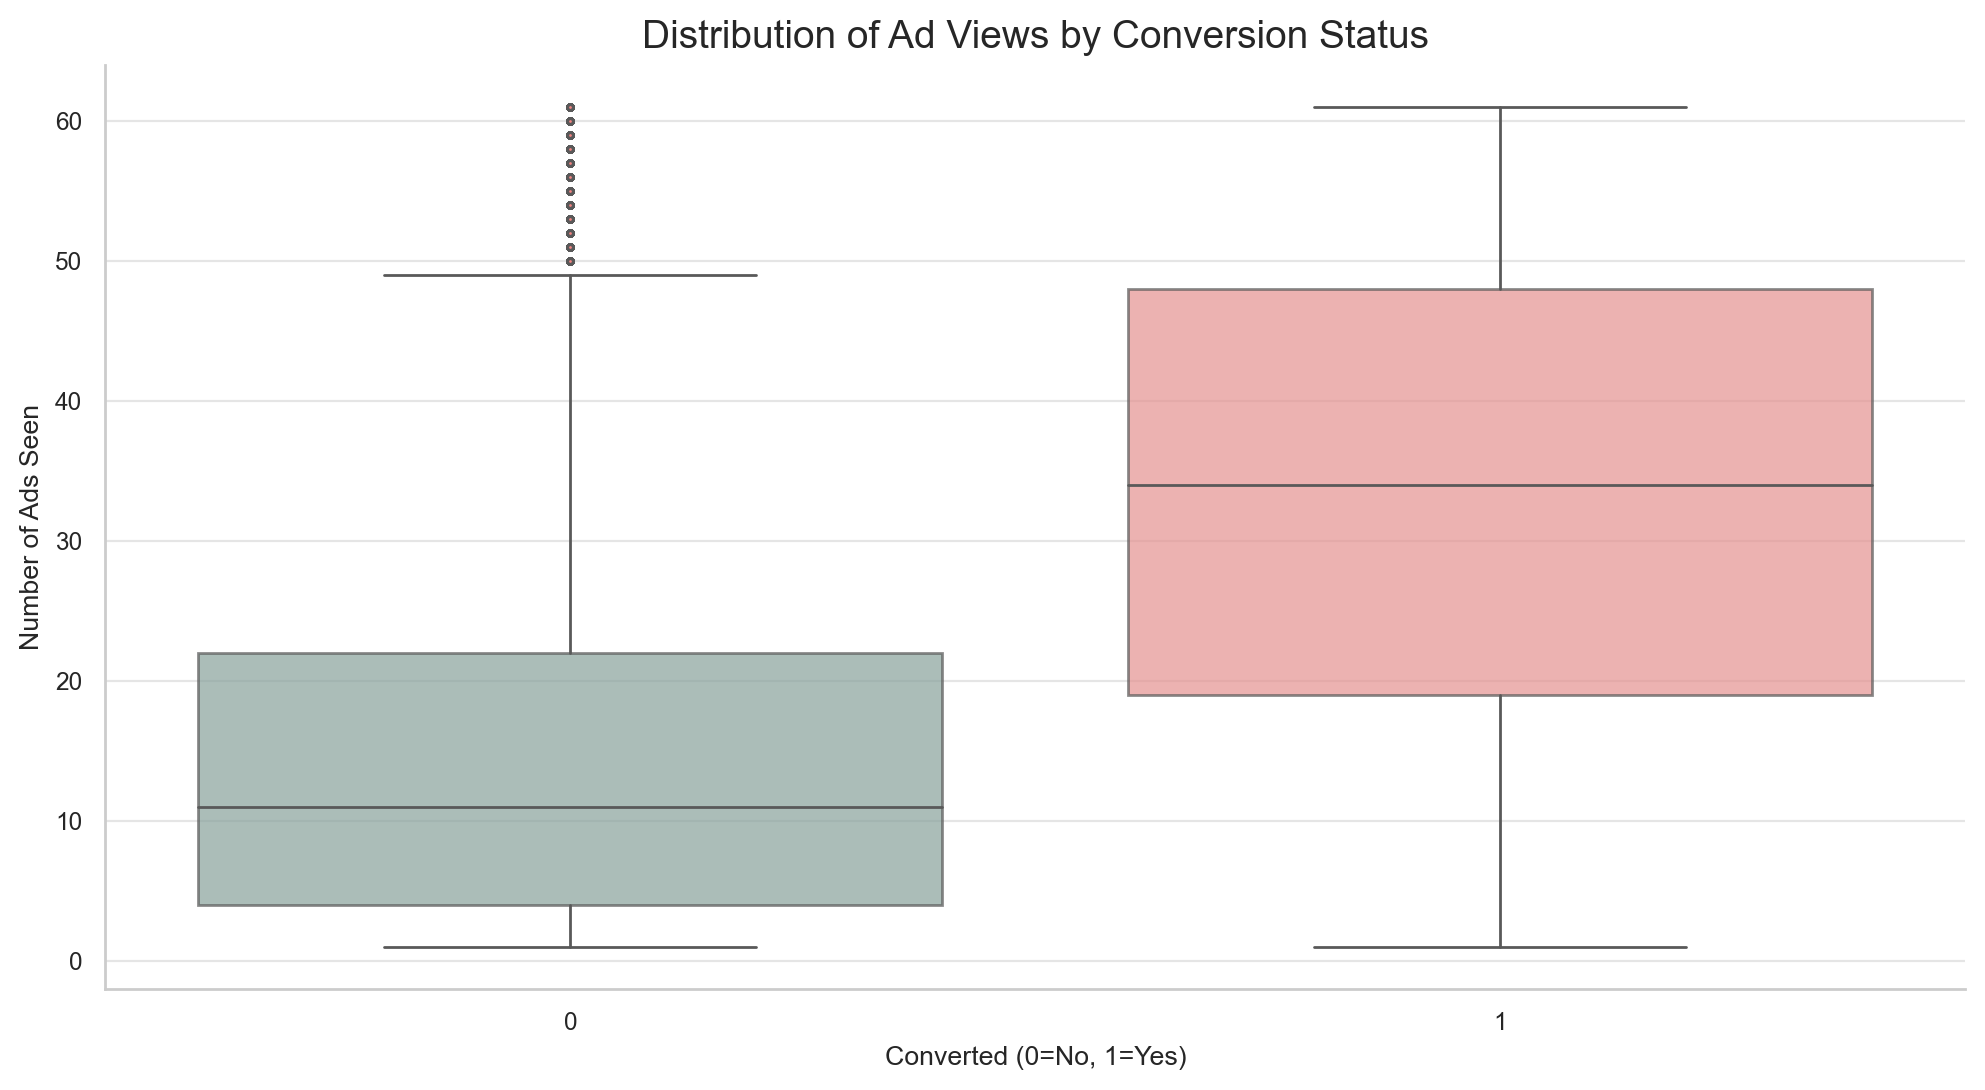

In [45]:
fig, ax = plt.subplots()

sns.boxplot(
    data=ad_campaign_clean,
    x='converted',
    y='total_ads',
    palette=custom_colors[3:],
    boxprops=dict(alpha=0.7),
    linewidth=1,
    flierprops={
        'marker': 'o',
        'markersize': 2,
        'markerfacecolor': custom_colors[4]  # Color for the outliers
    }
)
plt.title('Distribution of Ad Views by Conversion Status')
plt.xlabel('Converted (0=No, 1=Yes)')
plt.ylabel('Number of Ads Seen')

plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

In [46]:
def interpret_correlation(col_1, col_2, alpha=0.05):
    pointbi_corr, pointbi_p = stats.pointbiserialr(col_1, col_2)
    
    if p_value > alpha:
        return 'No significant correlation found (p > 0.05)'
    
    if abs(pointbi_corr) < 0.1:
        strength = 'negligible'
    elif abs(pointbi_corr) < 0.3:
        strength = 'weak'
    elif abs(pointbi_corr) < 0.5:
        strength = 'moderate'
    elif abs(pointbi_corr) < 0.7:
        strength = 'strong'
    else:
        strength = 'very strong'
        
    direction = 'positive' if pointbi_corr > 0 else 'negative'
    return print(f'Significant {strength} {direction} correlation is detected: r={pointbi_corr:.2f}, p < {alpha})')

In [47]:
result = interpret_correlation(ad_campaign_clean['total_ads'], ad_campaign_clean['converted'])

Significant weak positive correlation is detected: r=0.15, p < 0.05)


In [48]:
ad_data = ad_campaign_clean[ad_campaign_clean['test_group'] == 'ad']
ad_data.head()

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,1144181,ad,0,21,Tuesday,18
1,1496843,ad,0,17,Sunday,18
2,1448851,ad,0,21,Tuesday,19
3,1637531,ad,0,47,Wednesday,13
4,1081965,ad,0,61,Tuesday,20


In [49]:
ad_data_exp = ad_data.copy()

ad_data_exp['exposure_bins'] = pd.qcut(ad_data_exp['total_ads'], q=10, duplicates='drop', precision=0)

In [50]:
conversion_by_exposure = ad_data_exp.groupby('exposure_bins', observed=False).agg({
    'converted': ['count', 'mean', 'sum'],
    'total_ads': 'mean'
}).reset_index()

conversion_by_exposure.head(3)

exposure_bins converted             total_ads
                    count   mean  sum      mean
0    (0.0, 3.0]    119537 0.0021  254    1.7744
1    (3.0, 5.0]     50425 0.0034  173    4.5558
2    (5.0, 7.0]     40681 0.0040  164    6.4502

In [51]:
model = logit('converted ~ total_ads', data=ad_data_exp).fit()

print(model.params)
print(f'\nIntercept: {model.params.iloc[0]:.4f}\nSlope: {model.params.iloc[1]:.4f}')

Optimization terminated successfully.
         Current function value: 0.062669
         Iterations 9
Intercept   -5.7875
total_ads    0.0640
dtype: float64

Intercept: -5.7875
Slope: 0.0640


In [52]:
ad_data_exp['predicted_prob'] = model.predict(ad_data_exp)

# Calculate model accuracy (AUC score): 0.5=random, 1.0=perfect
auc_score = roc_auc_score(ad_data_exp['converted'], ad_data_exp['predicted_prob'])

# Define performance levels
auc_levels = {
   0.9: "Excellent",
   0.8: "Very good", 
   0.7: "Good",
   0.6: "Fair",
   0.5: "Poor"
}

# Find appropriate performance level
performance = next((v for k, v in auc_levels.items() if auc_score >= k), "Worse than random")
print(f"AUC: {auc_score:.3f} - {performance} model performance")

AUC: 0.797 - Good model performance


In [53]:
def find_optimal_ad_exposures(df, model):
    """
    Calculate optimal number of ad exposures by finding point of diminishing returns.
   
    Parameters:
        df: pd.DataFrame containing ad exposure data
        model: Fitted logistic regression model with intercept and slope parameters
   
    Returns:
        int: Optimal number of ad exposures where marginal returns start diminishing
       
    Formula:
        Marginal Return = slope * e^(intercept + slope*x) / (1 + e^(intercept + slope*x))^2,
        
        where x is number of ad exposures
    """
    # Calculates how much one additional ad increases conversion probability 
    # (finds slope at each point of the S-shaped logistic curve)
    def marginal_return(x, beta0, beta1):
        return beta1 * np.exp(beta0 + beta1 * x) / (1 + np.exp(beta0 + beta1 * x))**2
        
    # minimize() function: starts at mean ads -> tries different values(x) -> follows decreasing marginal returns 
    # -> stops at optimal point where adding more ads gives minimal benefit
    optimal_exposure = minimize(
        lambda x: -marginal_return(x, model.params.iloc[0], model.params.iloc[1]), # (-) turns minimization into maximization
        x0=df['total_ads'].mean(),
        bounds=[(df['total_ads'].min(), df['total_ads'].max())]
    ).x[0] # extract the only value
   
    return int(optimal_exposure)

# Apply the function
optimal_exposure = find_optimal_ad_exposures(ad_data_exp, model)
print(f'The optimal number of ads: {optimal_exposure}')

The optimal number of ads: 15


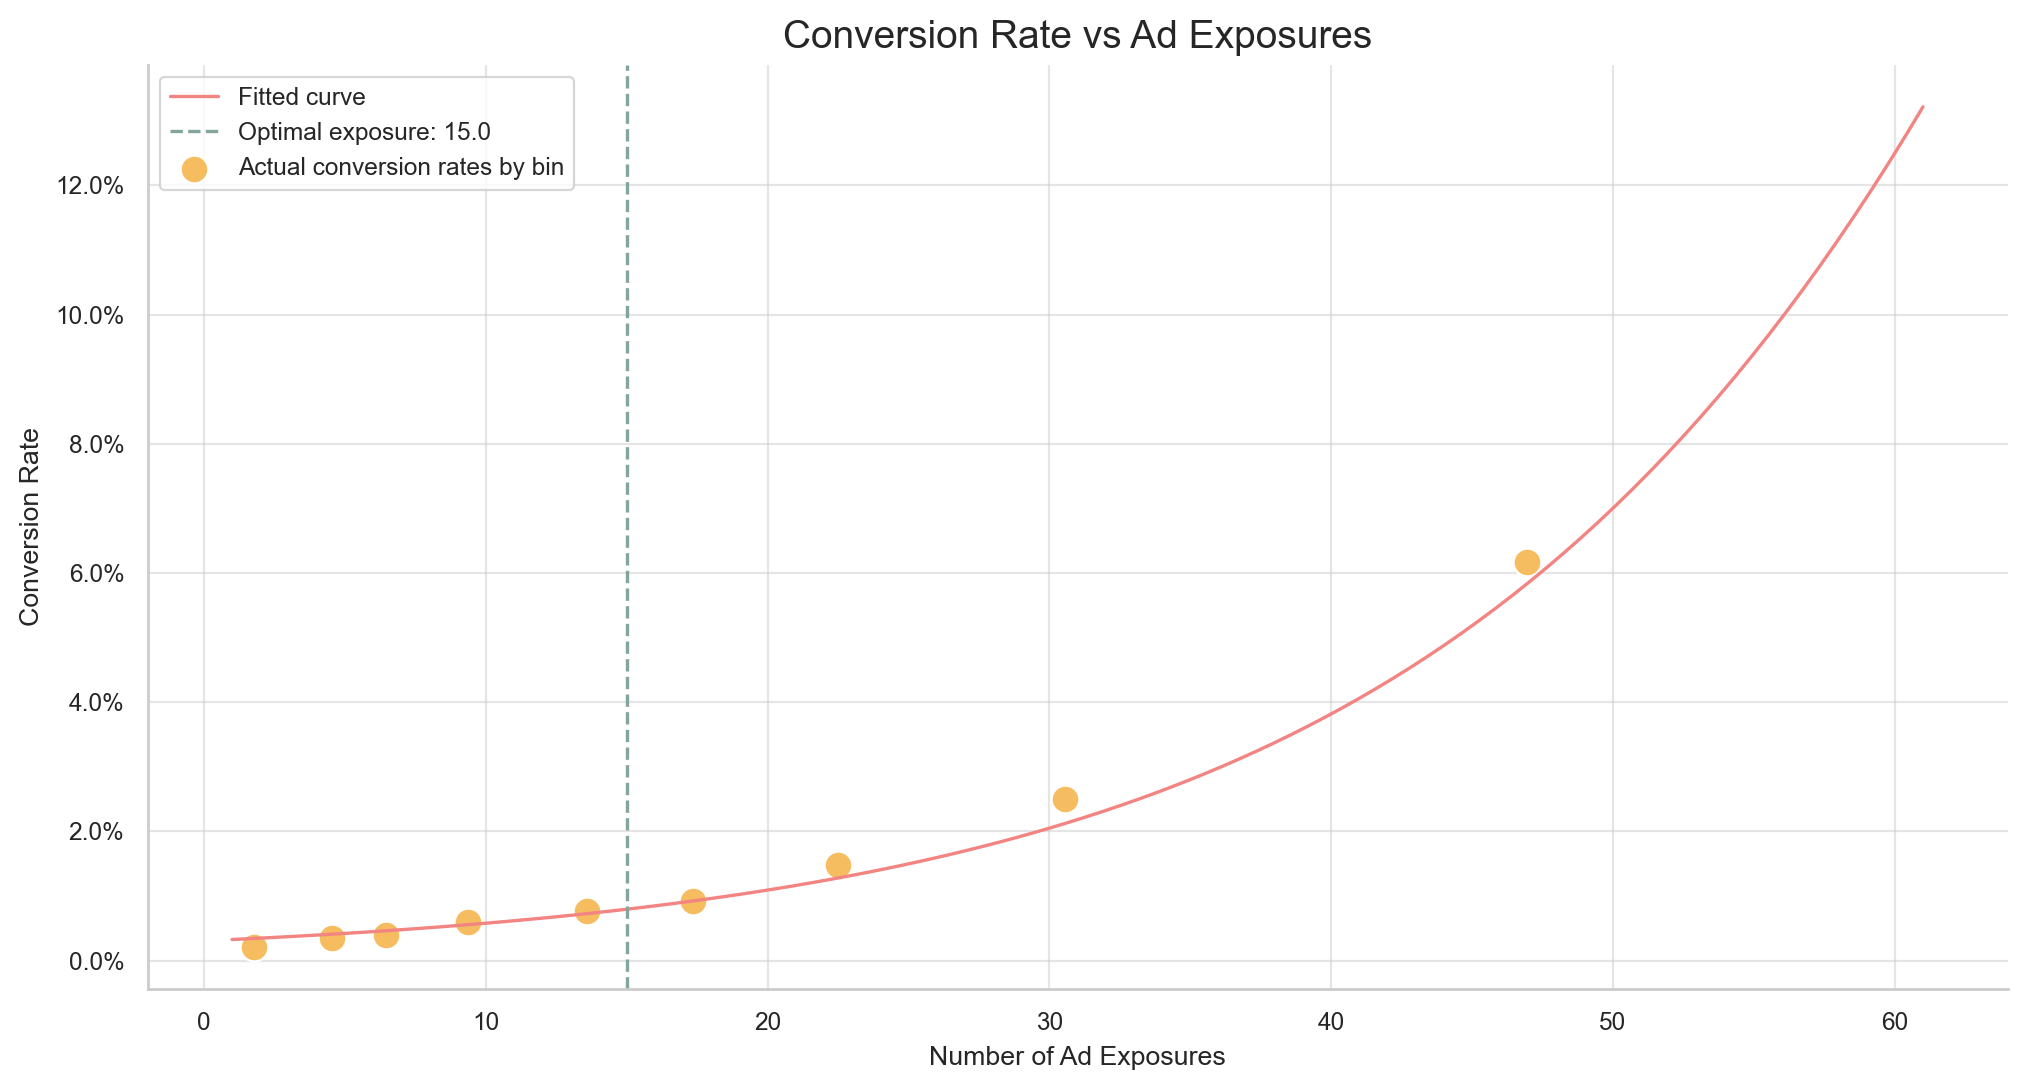

In [54]:
# Create visualization
fig, ax = plt.subplots()

x_range = np.linspace(ad_data_exp['total_ads'].min(), ad_data_exp['total_ads'].max(), 100)
y_pred = model.predict(pd.DataFrame({'total_ads': x_range}))

# Plot model's predicted conversion curve
sns.lineplot(x=x_range, y=y_pred, label='Fitted curve', color='#F28482')

# Mark optimal exposure point
ax.axvline(x=optimal_exposure, color='#84A59D', linestyle='--', label=f'Optimal exposure: {optimal_exposure:.1f}')

# Plot actual conversion rates by total_ads bin
sns.scatterplot(data=conversion_by_exposure, 
               x=('total_ads', 'mean'), # MultiIndex column: ('total_ads', 'mean')
               y=('converted', 'mean'), # MultiIndex column: ('converted', 'mean')
               s=100,
               label='Actual conversion rates by bin')

# Format y-axis as percentages
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))

plt.title('Conversion Rate vs Ad Exposures')
plt.xlabel('Number of Ad Exposures')
plt.ylabel('Conversion Rate')
# Remove the top and right spines
plt.gca().spines[['top', 'right']].set_visible(False)
plt.legend()
plt.show()

In [55]:
#temporal analysis

In [56]:
daily_conv = ad_data.groupby('most_ads_day').agg({'converted': 'mean'}).round(3).reset_index()

# Calculate mean of daily conversion rates (avg across weekdays)
daily_avg_conversion = daily_conv['converted'].mean()

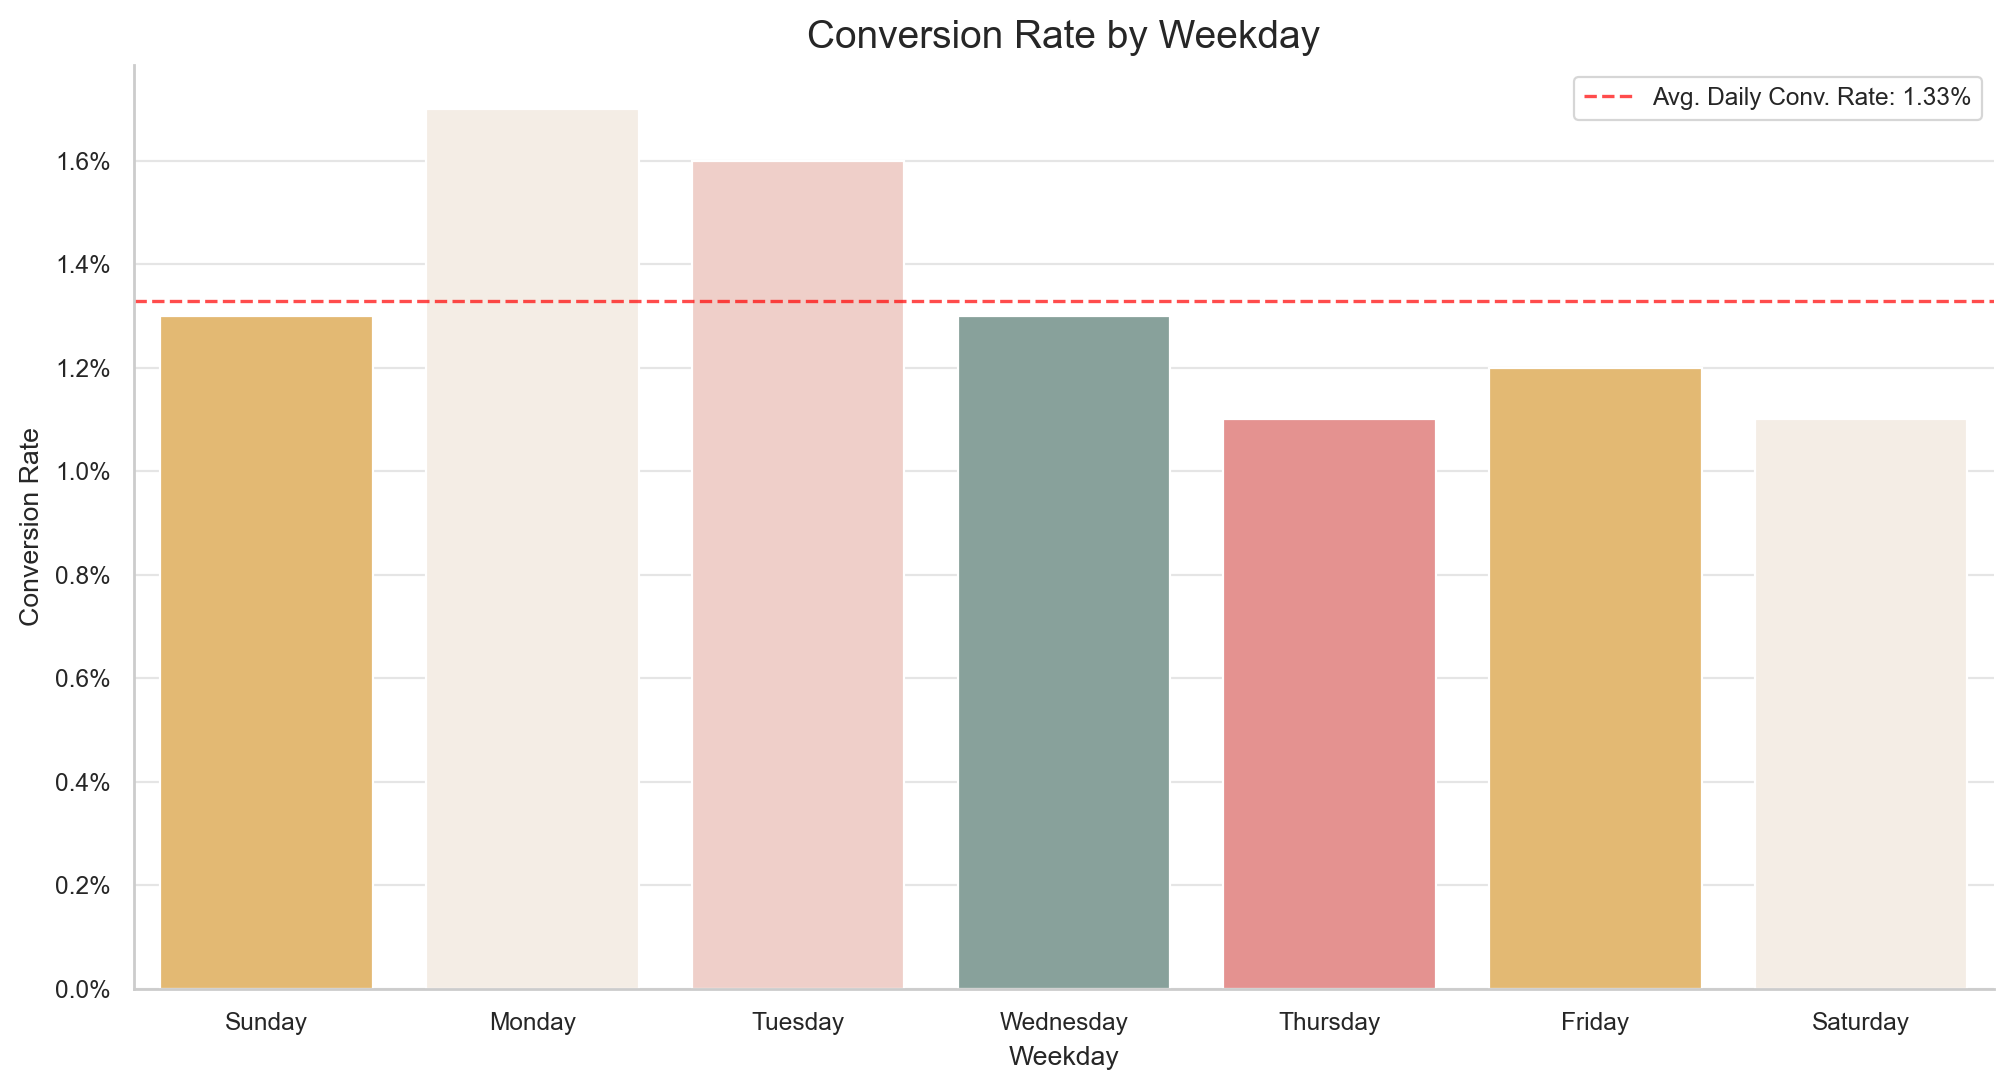

In [57]:
day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']


# Create the figure
fig, ax = plt.subplots()

sns.barplot(data=daily_conv, x='most_ads_day', y='converted', order=day_order, palette=custom_colors, ax=ax)

# Add reference line for average conversion rate
ax.axhline(y=daily_avg_conversion, linestyle='--', alpha=0.7, color='red', label=f'Avg. Daily Conv. Rate: {daily_avg_conversion:.2%}')

# Format y-axis as percentages
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))

plt.title('Conversion Rate by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Conversion Rate')

plt.legend()
# Remove the top and right spines
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

In [59]:
# Create contingency table for the further testing
contingency = pd.crosstab(ad_data['most_ads_day'], ad_data['converted'])

# Conduct the Chi-square test 
chi2_stat, p_value, _, _ = chi2_contingency(contingency)
print(f'Chi-square statistic: {chi2_stat:.4f}')
print(f'p-value: {p_value:.4f}')

if p_value < 0.05:
    print('\nReject the null hypothesis: There is a statistically significant difference in conversion rates across weekdays.')
else:
    print('\nFail to reject the null hypothesis: There is no statistically significant evidence of differences in conversion rates across weekdays.')

Chi-square statistic: 197.4258
p-value: 0.0000

Reject the null hypothesis: There is a statistically significant difference in conversion rates across weekdays.


In [60]:
# Compare each day against baseline(avg. across weekdays)
results = []
for day in ad_data['most_ads_day'].unique():
    day_data = ad_data[ad_data['most_ads_day'] == day]
    
    # Z-test against baseline
    stat, p_val = proportions_ztest(
        [day_data['converted'].sum()],
        [len(day_data)],
        value=daily_avg_conversion,
        alternative='larger'  # test for higher conversion
    )

    # Calculate the conversion lift
    lift = (day_data['converted'].mean() - daily_avg_conversion) / daily_avg_conversion * 100
    # Append list of values to the 'result' list
    results.append([day, day_data['converted'].mean(), lift, p_val])
    
    # Create df from list of lists
results_df = pd.DataFrame(results, columns=['Day', 'Conv Rate', 'Lift %', 'P-value'])
print(results_df.sort_values('Conv Rate', ascending=False))

         Day  Conv Rate   Lift %                   P-value
6     Monday     0.0174  31.3388   [9.847886411195401e-19]
0    Tuesday     0.0159  19.6495  [2.5116378444794103e-08]
2  Wednesday     0.0131  -1.2770      [0.6538722887079398]
1     Sunday     0.0131  -1.3173      [0.6635407229963548]
3     Friday     0.0119 -10.0601      [0.9997520032324506]
5   Thursday     0.0115 -13.6873      [0.9999979752693205]
4   Saturday     0.0108 -18.6911      [0.9999999999413033]


In [61]:
# Get unique days
days = ad_data['most_ads_day'].unique()

# Initialize an empty list to store the pairwise test results
results = []

# Iterate over all unique pairwise combinations of days
for day1, day2 in combinations(days, 2): # generating all pairwise combinations
    day1_data = ad_data[ad_data['most_ads_day'] == day1]['converted']
    day2_data = ad_data[ad_data['most_ads_day'] == day2]['converted']

    # Perform a two-sided z-test for the difference in conversion proportions
    stat, pval = proportions_ztest(
        count=[day1_data.sum(), day2_data.sum()], # number of convertions for each day
        nobs=[len(day1_data), len(day2_data)],    # number of users for each day
        alternative='two-sided'                   # test for any difference (not directional)
    )
    # Append results to the list, formatting values to 4 decimal places
    results.append([
        day1, day2,
        f"{day1_data.mean():.4f}", 
        f"{day2_data.mean():.4f}",
        f"{pval:.4f}"
    ])

# Create DataFrame and apply Bonferroni correction to the p-value
pairwise_df = pd.DataFrame(results, columns=['Day1', 'Day2', 'Conv1', 'Conv2', 'P-value'])
pairwise_df['Adjusted P-value'] = multipletests([float(p) for p in pairwise_df['P-value']], method='bonferroni')[1] # Extract adjusted p-values

# Change the way adj. p-values are displayed
pairwise_df['Adjusted P-value'] = pairwise_df['Adjusted P-value'].apply(lambda x: f"{x:.4f}")

# Show only significant differences (adjusted p-value < 0.05)
significant_pairs = pairwise_df[pairwise_df['Adjusted P-value'].astype(float) < 0.05].sort_values('Adjusted P-value')
print(significant_pairs)


         Day1       Day2   Conv1   Conv2 P-value Adjusted P-value
0     Tuesday     Sunday  0.0159  0.0131  0.0000           0.0000
1     Tuesday  Wednesday  0.0159  0.0131  0.0000           0.0000
2     Tuesday     Friday  0.0159  0.0119  0.0000           0.0000
3     Tuesday   Saturday  0.0159  0.0108  0.0000           0.0000
4     Tuesday   Thursday  0.0159  0.0115  0.0000           0.0000
8      Sunday   Saturday  0.0131  0.0108  0.0000           0.0000
10     Sunday     Monday  0.0131  0.0174  0.0000           0.0000
14  Wednesday     Monday  0.0131  0.0174  0.0000           0.0000
17     Friday     Monday  0.0119  0.0174  0.0000           0.0000
19   Saturday     Monday  0.0108  0.0174  0.0000           0.0000
20   Thursday     Monday  0.0115  0.0174  0.0000           0.0000
12  Wednesday   Saturday  0.0131  0.0108  0.0001           0.0021


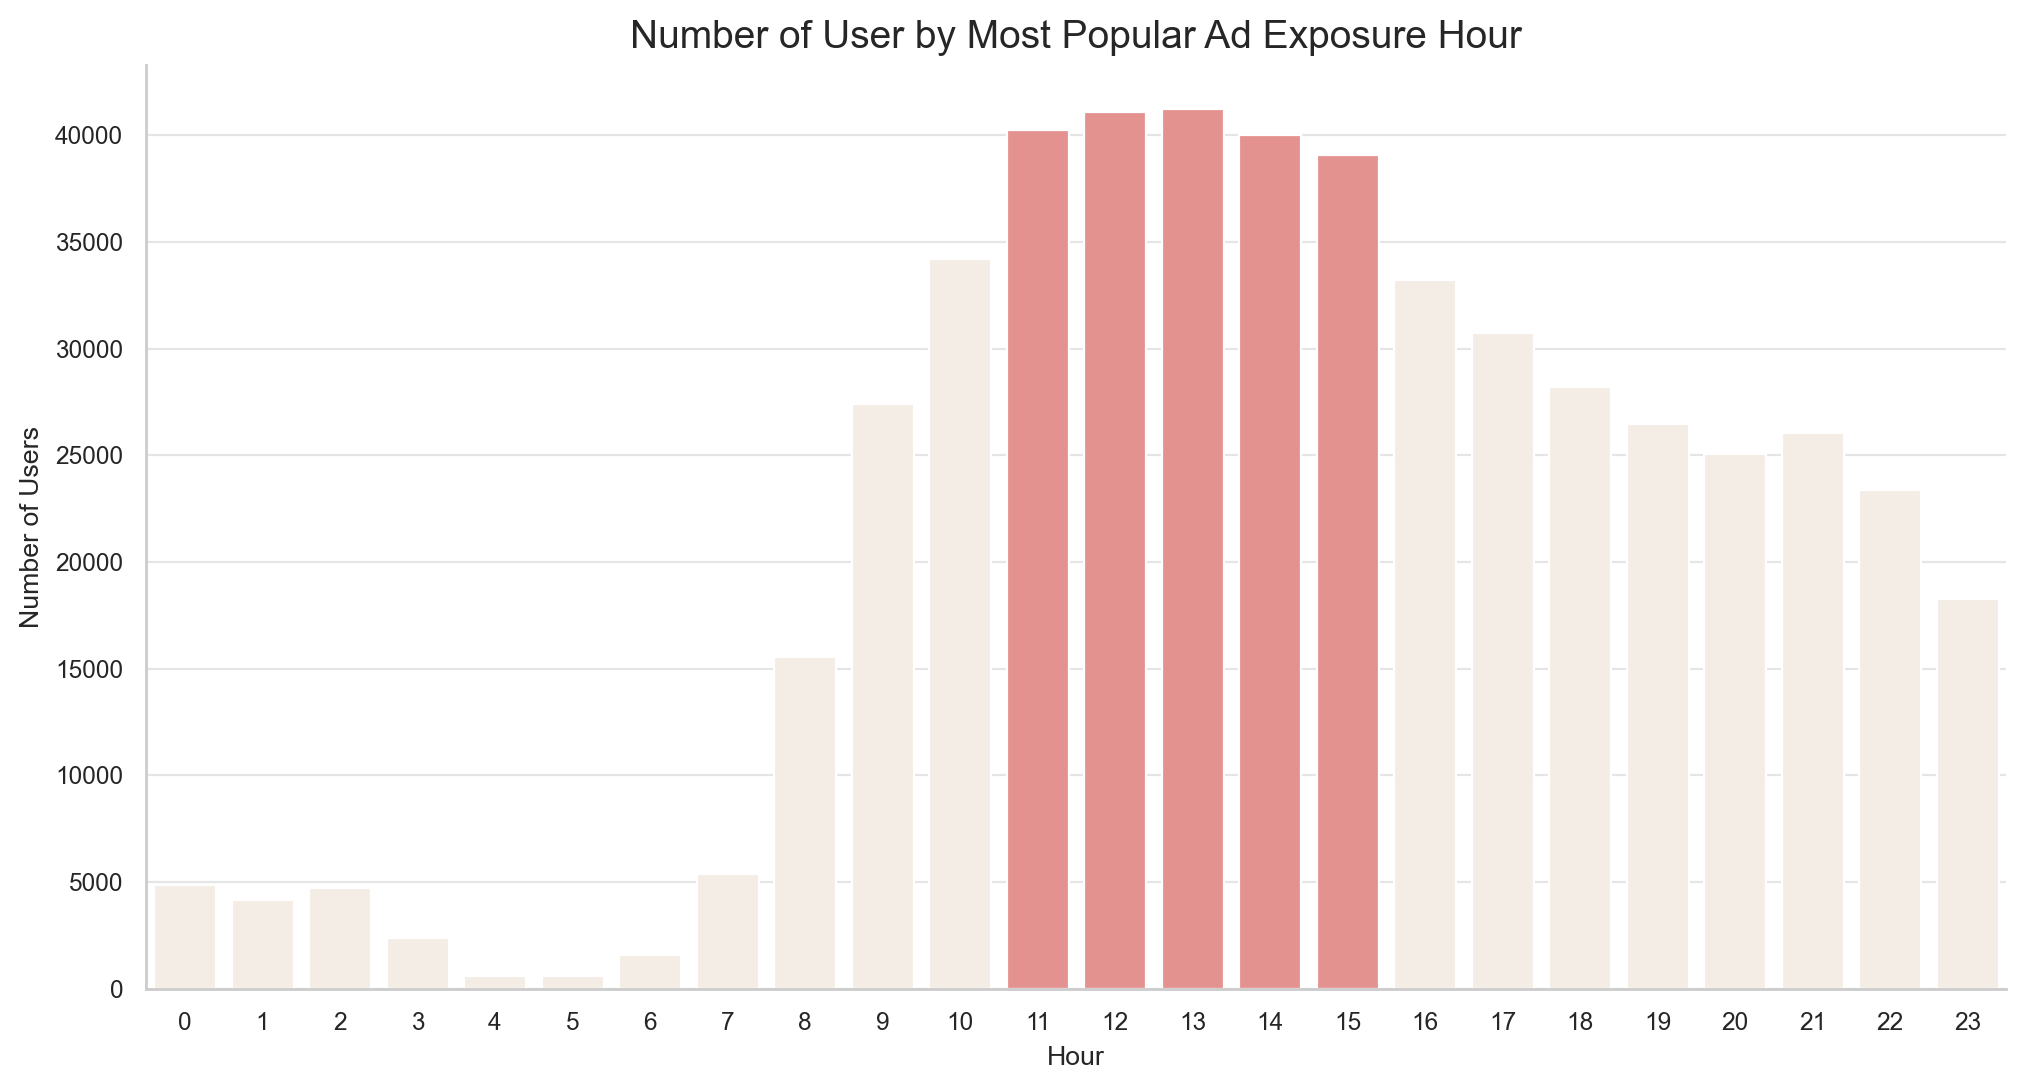

In [62]:
# Create the figure
fig, ax = plt.subplots()

# Get top 5 hours
top_5_hour_seen = ad_data['most_ads_hour'].value_counts().head(5).index.tolist()
colors = [custom_colors[4] if hour in top_5_hour_seen else custom_colors[1] for hour in sorted(ad_data['most_ads_hour'].unique())]

sns.countplot(data=ad_data, x='most_ads_hour', palette=colors, ax=ax)

plt.title('Number of User by Most Popular Ad Exposure Hour')
plt.xlabel('Hour')
plt.ylabel('Number of Users')

# Remove the top and right spines
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

In [63]:
# Calculate avg conversion for each hour
hourly_conv = ad_data.groupby('most_ads_hour').agg({'converted': 'mean'}).round(3).reset_index()

# Calculate mean of daily conversion rates (avg across weekdays)
hourly_avg_conversion = hourly_conv['converted'].mean()

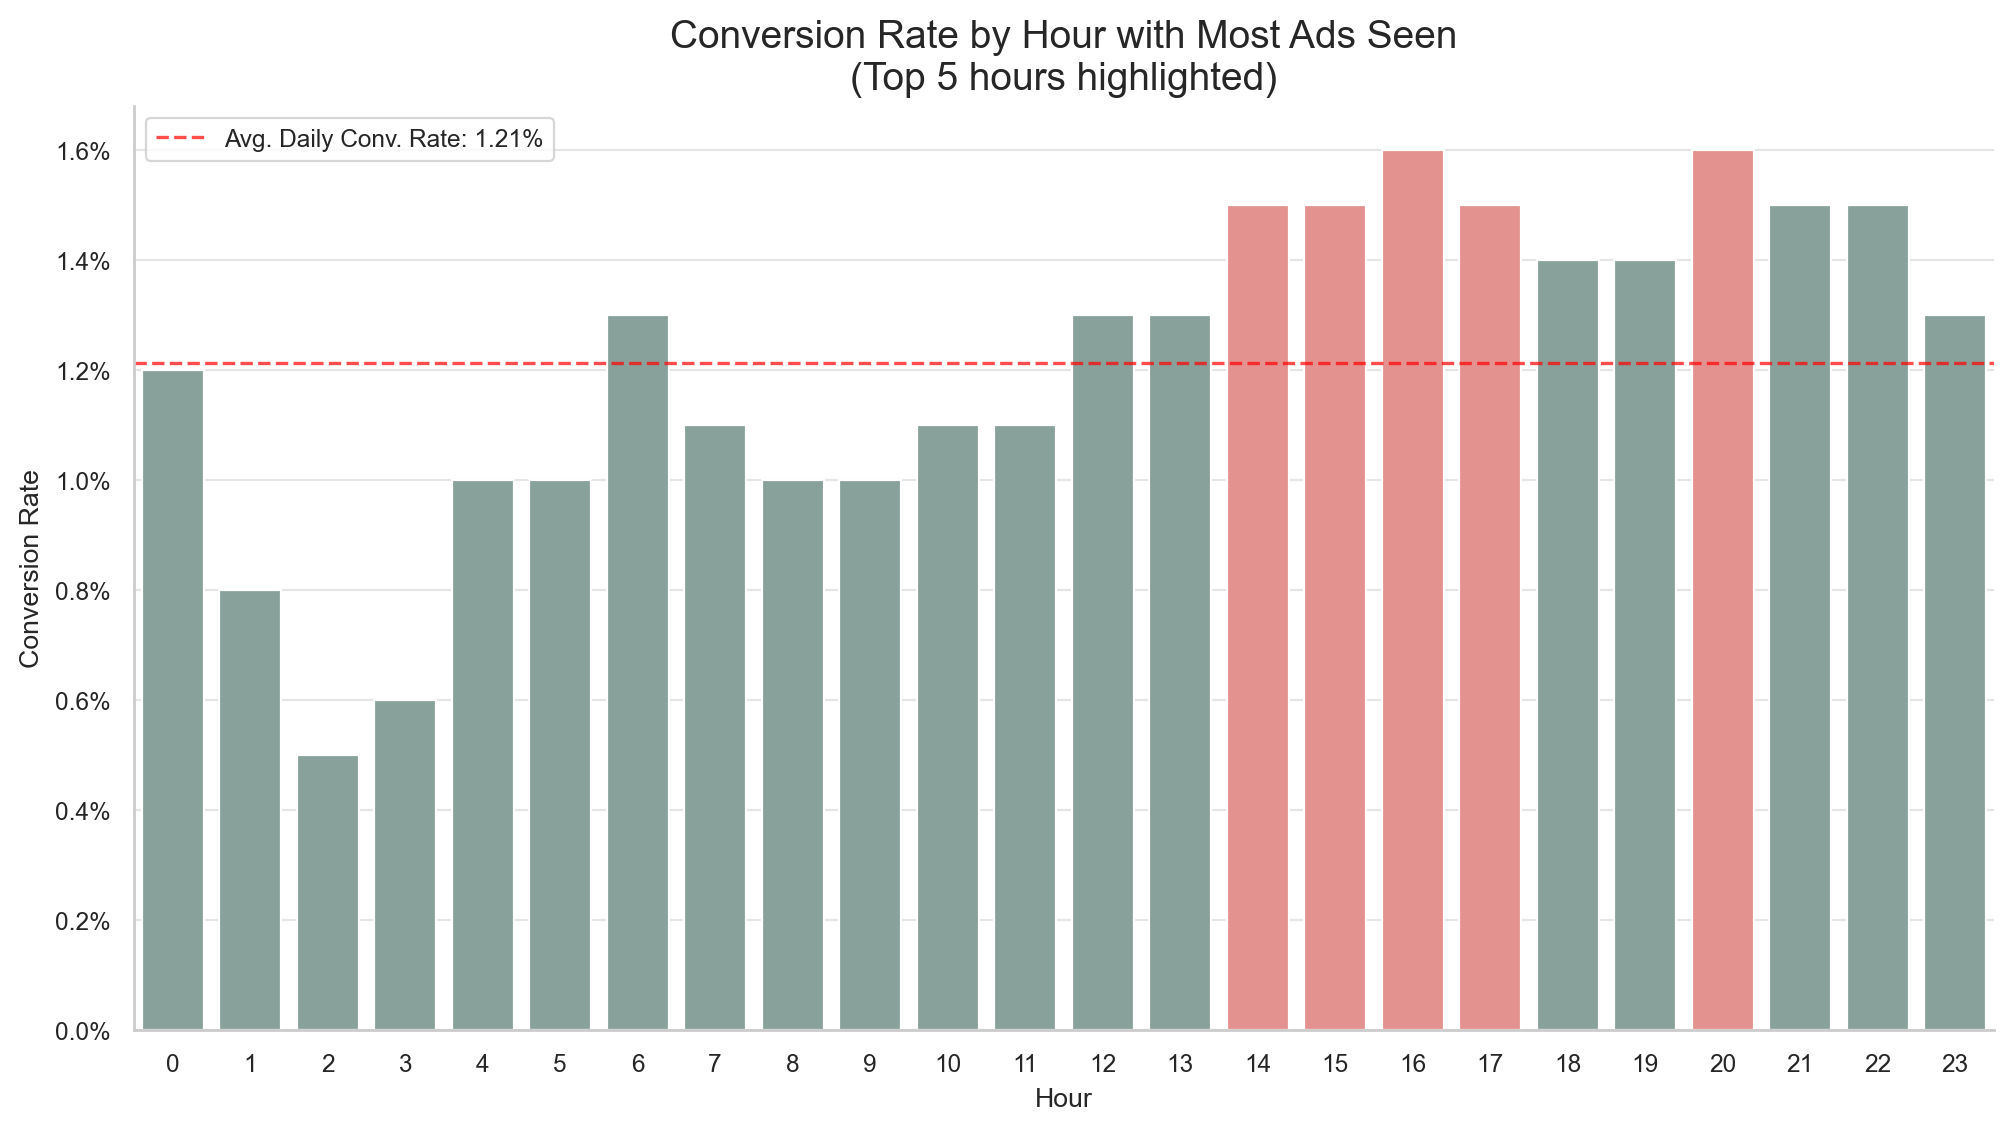

In [64]:
# Create figure
fig, ax = plt.subplots()

# Get top 5 hours
top_5_hours = hourly_conv.nlargest(5, 'converted')['most_ads_hour']

# Create bar plot with custom colors
colors = [custom_colors[4] if x in top_5_hours.values else custom_colors[3] for x in hourly_conv['most_ads_hour']]

sns.barplot(data=hourly_conv, x='most_ads_hour', y='converted', palette=colors, errorbar=('ci', 95), ax=ax)

# Add average line and formatting
ax.axhline(y=hourly_avg_conversion, linestyle='--', alpha=0.7, color='red', label=f'Avg. Daily Conv. Rate: {hourly_avg_conversion:.2%}')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))


# Labels and styling
plt.title('Conversion Rate by Hour with Most Ads Seen\n(Top 5 hours highlighted)')
plt.xlabel('Hour')
plt.ylabel('Conversion Rate')
plt.legend()
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()


In [65]:
# Create contingency table for the further testing
contingency = pd.crosstab(ad_data['most_ads_hour'], ad_data['converted'])

# Conduct the Chi-square test 
chi2_stat, p_value, _, _ = chi2_contingency(contingency)
print(f'Chi-square statistic: {chi2_stat:.4f}')
print(f'p-value: {p_value:.4f}')

if p_value < 0.05:
    print('\nReject the null hypothesis: There is a statistically significant difference in conversion rates across hours.')
else:
    print('\nFail to reject the null hypothesis: There is no statistically significant evidence of differences in conversion rates across hours.')

Chi-square statistic: 195.3451
p-value: 0.0000

Reject the null hypothesis: There is a statistically significant difference in conversion rates across hours.


In [66]:
# Get unique hours
hours = ad_data['most_ads_hour'].unique()

# Initialize list for results
results = []

# Iterate over all unique pairwise combinations of hours
for hour1, hour2 in combinations(hours, 2):
    hour1_data = ad_data[ad_data['most_ads_hour'] == hour1]['converted']
    hour2_data = ad_data[ad_data['most_ads_hour'] == hour2]['converted']
    
    # Perform z-test for difference in conversion proportions
    stat, pval = proportions_ztest(
        count=[hour1_data.sum(), hour2_data.sum()],    # conversions per hour
        nobs=[len(hour1_data), len(hour2_data)],       # users per hour
        alternative='larger'
    )
    # Add the result to results list
    results.append([
    hour1, hour2, 
    hour1_data.mean(),
    hour2_data.mean(),
    pval
    ])

# Create DataFrame and apply Bonferroni correction
pairwise_df = pd.DataFrame(results, columns=['Hour1', 'Hour2', 'Conv1', 'Conv2', 'P-value'])
pairwise_df['Adjusted P-value'] = multipletests(
    [float(p) for p in pairwise_df['P-value']], 
    method='bonferroni'
)[1]

# Format adjusted p-values
pairwise_df['Adjusted P-value'] = pairwise_df['Adjusted P-value'].apply(lambda x: f"{x:.4f}")

# Show significant differences
significant_pairs = pairwise_df[
    pairwise_df['Adjusted P-value'].astype(float) < 0.05
].sort_values('Adjusted P-value')

#print(significant_pairs)
        

In [67]:
# Perform groupby and aggregation
grouped = significant_pairs.groupby('Hour1').agg({
    'Hour1': 'count',  # Count occurrences
    'Conv1': 'mean'    # Calculate mean of Conv1
}).rename(columns={'Hour1': 'Num of Comparisons', 'Conv1': 'Conv. Rate'}).reset_index()  # Rename column

# Sort by 'count' (descending) and then by 'Conv1' (descending)
sorted_grouped = grouped.sort_values(by=['Num of Comparisons', 'Conv. Rate'], ascending=[False, False])

# Select the top 5 rows
top_5_hours = sorted_grouped.head(5)

print(top_5_hours)

    Hour1  Num of Comparisons  Conv. Rate
14     20                   8      0.0162
10     16                   7      0.0163
15     21                   6      0.0152
16     22                   4      0.0155
11     17                   4      0.0152
